#**GROUP 8 REPORT**
##Foundations of Data Science
###August 13, 2024


---





#1. OBJECTIVES

The objective of our project is to use historical video game and console/platform sales data to determine whether there is a discernable relationship between the release of certain video games and the success (or failure) of the consoles/platforms for which the games were developed.

#2. DATA PREPARATION


##Data Sources
Several data sources were used in our analysis:

1. A file of video game sales for 64,016 titles released from 1971-2024, sourced from the [Maven Analytics Data Playground](https://www.mavenanalytics.io/data-playground), which itself was sourced from Kaggle. A data dictionary was also provided along with this file, so we loaded that as well for reference.
2. Weekly console sales from November 22, 2004 to July 1, 2024, scraped from chart data found at [vgchartz.com](https://www.vgchartz.com/tools/hw_date.php).
3. Public information from various online sources, compiled using ChatGPT and verified manually, to create a cross-reference file of platform names and release years, used to augment data from the above two datasets.


The following code blocks bring in the datasets.

###Imports

In [ ]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
from google.colab import drive, files
import io
from datetime import timedelta
from pandas.plotting import autocorrelation_plot

###Load video game sales dataset and associated dictionary

In [ ]:
drive.mount('/content/drive')
file_path='/content/drive/MyDrive/Group 8 - Foundations of Data Science/vgchartz-2024.csv'
video_game_sales = pd.read_csv(file_path)
video_game_sales.head(1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,NaN


In [ ]:
file_path='/content/drive/MyDrive/Group 8 - Foundations of Data Science/vg_data_dictionary.csv'
dictionary = pd.read_csv(file_path)

###Load weekly console sales dataset and convert Epoch time to calendar dates

In [ ]:
url = 'https://www.vgchartz.com/tools/hw_date.php'
r = requests.get(url)
soup = BeautifulSoup(r.content, 'html.parser')
script = soup.find_all('script')[32].text.strip()[1465:-11]
pattern = re.compile(r"name:'([^']*)',\s*data:\s*\[(.*?)\]", re.DOTALL)

all_data = []

matches = pattern.findall(script)

for match in matches:
    name = match[0]
    data_section = match[1]

    data_matches = re.findall(r"x:\s*(\d+),\s*y:\s*(\d+)", data_section)

    for data in data_matches:
        all_data.append([name, int(data[0]), int(data[1])])

def wk_of(date):
    return date - pd.offsets.Week(weekday=0) if date.weekday() != 0 else date

wcs = pd.DataFrame(all_data, columns=['name', 'x', 'y'])
wcs['week_of'] = pd.to_datetime(wcs['x'], unit='ms').apply(wk_of)
wcs = wcs.drop(['x'], axis=1).rename(columns={'name':'console', 'y':'units_sold'})
wcs.head(1)

,console,units_sold,week_of
0,Wii,529658,2006-11-20


##Data Quality

We evaluated the data in several ways to determine quality and identify preparation required.

###Checking the video game sales file

In [ ]:
video_game_sales.drop(columns=['img'], inplace=True)
video_game_sales.head(1)

,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
0,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,NaN


In [ ]:
video_game_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   img           64016 non-null  object 
 1   title         64016 non-null  object 
 2   console       64016 non-null  object 
 3   genre         64016 non-null  object 
 4   publisher     64016 non-null  object 
 5   developer     63999 non-null  object 
 6   critic_score  6678 non-null   float64
 7   total_sales   18922 non-null  float64
 8   na_sales      12637 non-null  float64
 9   jp_sales      6726 non-null   float64
 10  pal_sales     12824 non-null  float64
 11  other_sales   15128 non-null  float64
 12  release_date  56965 non-null  object 
 13  last_update   17879 non-null  object 
dtypes: float64(6), object(8)
memory usage: 6.8+ MB


Looking at the info about the video_game_sales dataframe we can see that several fields are missing a significant amount of data. We can also see that the 'release_date' and 'last_update' fields are objects, so we will need to convert them to datetime format.

Since the time frame of our analysis is within the past 20 years, given the data in the console sales data, it is most important to have relatively complete video game sales in that time frame. As such, we eliminated records in the video game file prior to 2004 and re-ran the info method.

In [ ]:
video_game_sales[['release_date','last_update']] = video_game_sales[['release_date','last_update']].apply(pd.to_datetime)
recent_vg_sales = video_game_sales.loc[(video_game_sales['release_date'] >= '2004-01-01')]
recent_vg_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38115 entries, 0 to 64014
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   img           38115 non-null  object        
 1   title         38115 non-null  object        
 2   console       38115 non-null  object        
 3   genre         38115 non-null  object        
 4   publisher     38115 non-null  object        
 5   developer     38106 non-null  object        
 6   critic_score  5112 non-null   float64       
 7   total_sales   14590 non-null  float64       
 8   na_sales      9469 non-null   float64       
 9   jp_sales      5384 non-null   float64       
 10  pal_sales     9448 non-null   float64       
 11  other_sales   11293 non-null  float64       
 12  release_date  38115 non-null  datetime64[ns]
 13  last_update   11620 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(6), object(6)
memory usage: 4.4+ MB


Fortunately, once this date filter is applied, the 'release_date' field has the same number of non-null values as the total file (38,115).

There are varying numbers of non-null records across the different sales fields (total and regional), though it's not clear whether this is due to rows where all sales values are missing or rows with partial sales data (i.e. total but not regional or vice-versa). We used a heat map to evaluate this.

<Axes: >

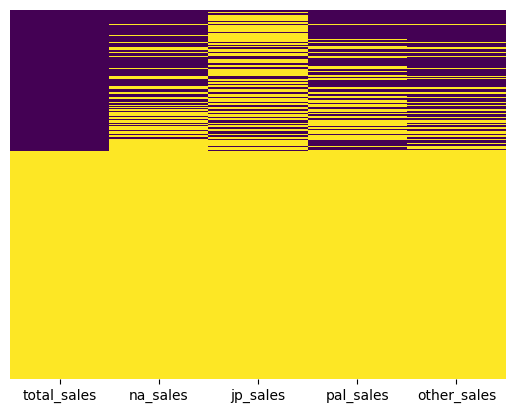

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

recent_vg_sales_cols = recent_vg_sales[['total_sales','na_sales','jp_sales','pal_sales','other_sales']]
sns.heatmap(recent_vg_sales_cols.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Based on this analysis, a record with any sales data whatsoever will have data in the 'total_sales' column, and may or may not have data in the regional sales columns. There are 23,525 records without any sales data (38,115 total records - 14,590 non-null records in the 'total_sales' column).

##Data Preparation

###Date Alignment

In order to match data from the two datasets (game sales and console sales) on time series, we needed to normalize the date information.

The game sales file contains release dates that can fall on any day of the week, while the console sales data is weekly with dates representing the Monday of the week of the sales data provided.

In [ ]:
def wk_of(date):
    return date - pd.offsets.Week(weekday=0) if date.weekday() != 0 else date

recent_vg_sales = recent_vg_sales[recent_vg_sales['release_date'].notnull()].copy()
recent_vg_sales['week_of'] = recent_vg_sales['release_date'].apply(wk_of)
recent_vg_sales.head(1)

,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update,week_of
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,NaT,2013-09-16


###Merging console sales

With a 'week_of' field created in the video game sales dataframe, we can now merge in the associated consoles' sales for that week.

In [ ]:
combined_sales = (pd.merge(left=wcs,
                           right=recent_vg_sales,
                           how='left',
                           left_on=['console', 'week_of'],
                           right_on=['console', 'week_of']))
combined_sales = combined_sales.rename(columns={'units_sold': 'consoles_sold'})
combined_sales['consoles_sold'] = combined_sales['consoles_sold'].fillna(0).astype('int32')
combined_sales.head(1)

,console,consoles_sold,week_of,img,title,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
0,Wii,529658,2006-11-20,/games/boxart/5275800ccc.jpg,Rapala Tournament Fishing!,Sports,Activision,Magic Wand Productions,NaN,0.55,0.51,NaN,0.0,0.04,2006-11-22,NaT


In [ ]:
combined_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19324 entries, 0 to 19323
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   console        19324 non-null  object        
 1   consoles_sold  19324 non-null  int32         
 2   week_of        19324 non-null  datetime64[ns]
 3   img            17483 non-null  object        
 4   title          17483 non-null  object        
 5   genre          17483 non-null  object        
 6   publisher      17483 non-null  object        
 7   developer      17480 non-null  object        
 8   critic_score   2832 non-null   float64       
 9   total_sales    10669 non-null  float64       
 10  na_sales       7065 non-null   float64       
 11  jp_sales       4699 non-null   float64       
 12  pal_sales      6103 non-null   float64       
 13  other_sales    7879 non-null   float64       
 14  release_date   17483 non-null  datetime64[ns]
 15  last_update    7492

#3. ANALYSIS

To determine whether the release of flagship games on each platform affects the sales of the console/platform itself, we can first identify the best-selling games on each console/platform.

In [ ]:
combined_sales[['total_sales', 'na_sales', 'jp_sales', 'pal_sales', 'other_sales']] = combined_sales[['total_sales', 'na_sales', 'jp_sales', 'pal_sales', 'other_sales']].apply(pd.to_numeric, errors='coerce')
combined_sales.dropna(subset=['console', 'total_sales'], inplace=True)
max_selling_games = combined_sales.loc[combined_sales.groupby('console')['total_sales'].idxmax()]

print("Max-selling game on each console:\n", max_selling_games[['console', 'title', 'total_sales']])

Max-selling game on each console:
       console                                   title  total_sales
11540     3DS                         Dragon Quest XI         1.82
3725       DS                            Cooking Mama         5.66
17664      NS                               Minecraft         1.89
7965      PS3                      Grand Theft Auto V        20.32
13510     PS4                      Grand Theft Auto V        19.39
8614      PSP  Grand Theft Auto: Liberty City Stories         7.72
12203     PSV                               Minecraft         2.47
1524      Wii                            Just Dance 4         6.89
13261    WiiU                               Minecraft         1.47
3092     X360                      Grand Theft Auto V        15.86
15707    XOne                      Grand Theft Auto V         8.72


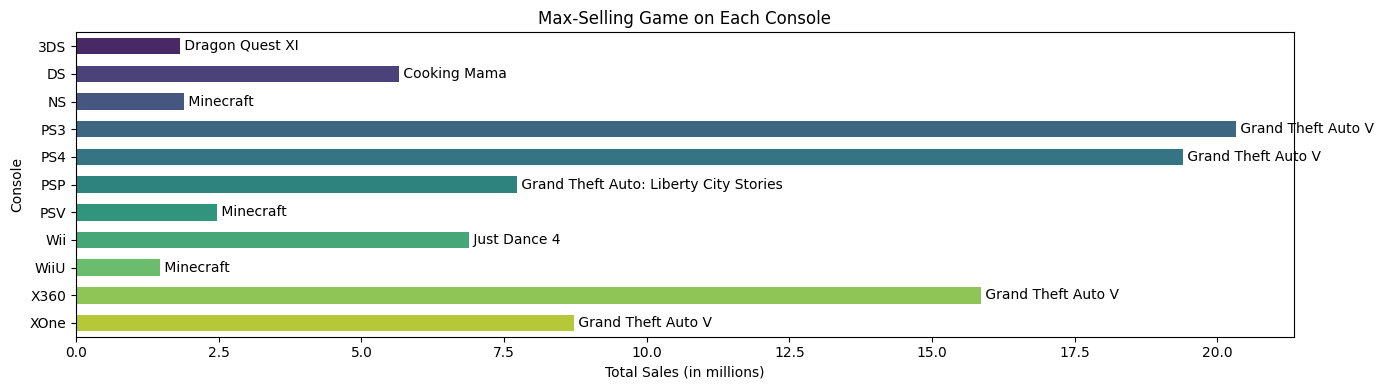

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.figure(figsize=(14, 4))
sns.barplot(x='total_sales', y='console', data=max_selling_games, orient='h', palette='viridis', width=0.6)
# Add the titles to the plot
for index, value in enumerate(max_selling_games['total_sales']):
    plt.text(value, index, f" {max_selling_games['title'].iloc[index]}", va='center')

plt.title('Max-Selling Game on Each Console')
plt.xlabel('Total Sales (in millions)')
plt.ylabel('Console')
plt.tight_layout()
plt.show()

This function is designed to analyze and visualize the impact of a game's release on console sales over time. The primary goal of the function is to assess whether the release of a specific game influences the sales of its associated console. It does this by plotting console sales data from several weeks before and after the game's release, allowing for a visual inspection of any trends or patterns that might indicate a relationship between the game's release and console sales. We have used 13 weeks, or one quarter, as the time range pre- and post-launch.

The function takes an 'adjustment factor' argument, which is plotted below as "Pre-launch Threshold", to account for anticipatory increases in console sales ahead of a game's release. We have used a default value of 2 (meaning two weeks) in our analyses.

In [ ]:
#Function to produce line chart showing console sales pre- and post-launch of a given title

def console_sales_pre_post_release(title, console, weeks, adj_factor):
  launch_week = combined_sales.loc[combined_sales['title'] == title, 'week_of'].iloc[0]
  adj_launch_week = launch_week - timedelta(weeks=adj_factor)
  min = launch_week - timedelta(weeks=weeks) - timedelta(weeks=adj_factor)
  max = launch_week + timedelta(weeks=weeks) - timedelta(weeks=adj_factor)
  df = combined_sales[(combined_sales['console'] == console) & (combined_sales['week_of'] >= min) & (combined_sales['week_of'] <= max)]
  df = df[['week_of', 'consoles_sold']].groupby(['week_of']).min()
  plot_title = console + " Units Sold Around Launch of " + title
  y_label = console + " Units Sold"

  plt.figure(figsize=(8, 2))
  sns.lineplot(data=df, x='week_of', y='consoles_sold')

  plt.axvline(x=adj_launch_week, color='orange', linestyle=':', label="Pre-launch Threshold")
  plt.axvline(x=launch_week, color='red', linestyle='--', label="Game Launched")


  plt.xlabel('Week Of')
  plt.ylabel(y_label)
  plt.title(plot_title)
  plt.legend()

  return plt.show()

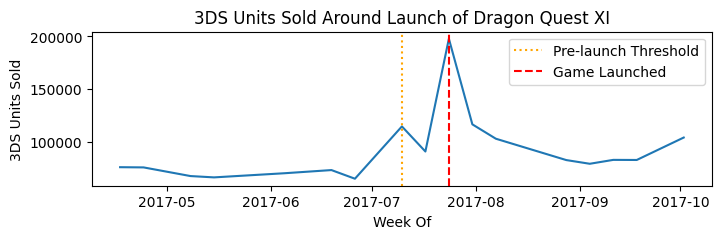

In [ ]:
console_sales_pre_post_release('Dragon Quest XI', '3DS', 13, 2)

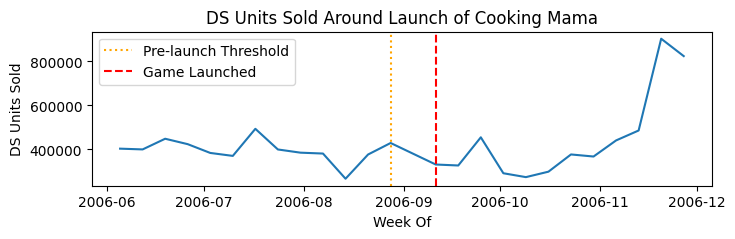

In [ ]:
console_sales_pre_post_release('Cooking Mama', 'DS', 13, 2)

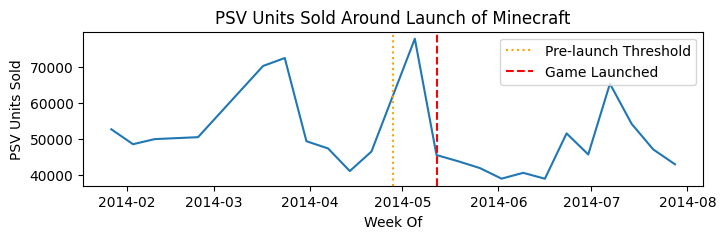

In [ ]:
console_sales_pre_post_release('Minecraft', 'PSV', 13, 2)

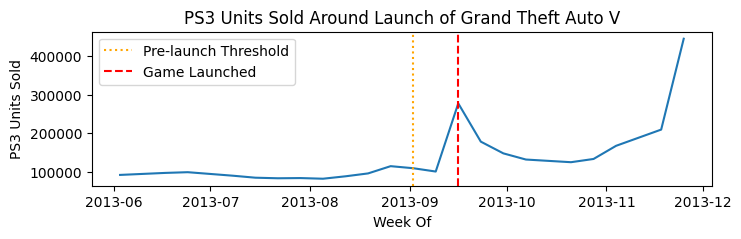

In [ ]:
console_sales_pre_post_release('Grand Theft Auto V', 'PS3', 13, 2)

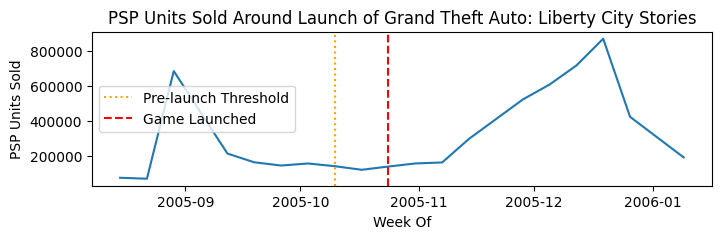

In [ ]:
console_sales_pre_post_release('Grand Theft Auto: Liberty City Stories', 'PSP', 13, 2)

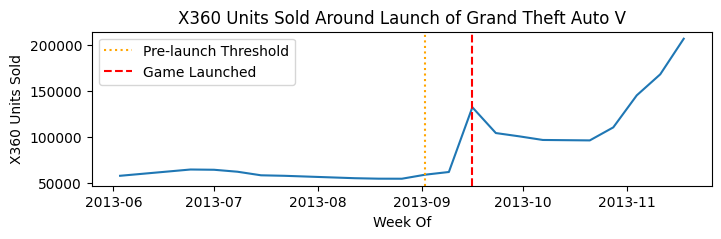

In [ ]:
console_sales_pre_post_release('Grand Theft Auto V', 'X360', 13, 2)

Based on the plots above, the release of a single flagship game appears to have a limited long-term impact on console sales. Although there might be a short-term sales spike around the game release week, this effect often does not persist.The data indicates that significant sales fluctuations are not always directly related to the game release, suggesting that the impact of a single game might be overshadowed by other variables.

Therefore, we can further explore the correlation between the frequency of game releases on different platforms and console sales.

In [ ]:
games_df=pd.pivot_table(recent_vg_sales, values=['total_sales','title'], index=['week_of','console'],
               aggfunc={'total_sales':"sum", 'title':"count"}, fill_value=0).reset_index()
games_df.head(1)

,week_of,console,title,total_sales
0,2003-12-29,All,1,0.0


In [ ]:
game_vs_console=pd.merge(games_df, wcs, how="outer", on=["console","week_of"]).dropna()
game_vs_console.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4010 entries, 309 to 8747
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   week_of      4010 non-null   datetime64[ns]
 1   console      4010 non-null   object        
 2   title        4010 non-null   float64       
 3   total_sales  4010 non-null   float64       
 4   units_sold   4010 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 188.0+ KB


The goal of the 'game_vs_console' DataFrame is to analyze the relationship between game releases and console sales over time. By merging game release data with console sales data, this DataFrame allows for a comprehensive analysis of how the timing and frequency of game releases might impact the sales performance of the respective consoles.

In [ ]:
game_vs_console['mth']=pd.to_datetime(game_vs_console['week_of']).dt.strftime('%m').astype('int32')
game_vs_console['week_num']=pd.to_datetime(game_vs_console['week_of']).dt.isocalendar().week
game_vs_console['yr']=game_vs_console['week_of'].dt.year.astype('int32')
game_vs_console.head(1)

,week_of,console,title,total_sales,units_sold,mth,week_num,yr
309,2004-11-29,DS,5.0,0.45,651898.0,11,49,2004


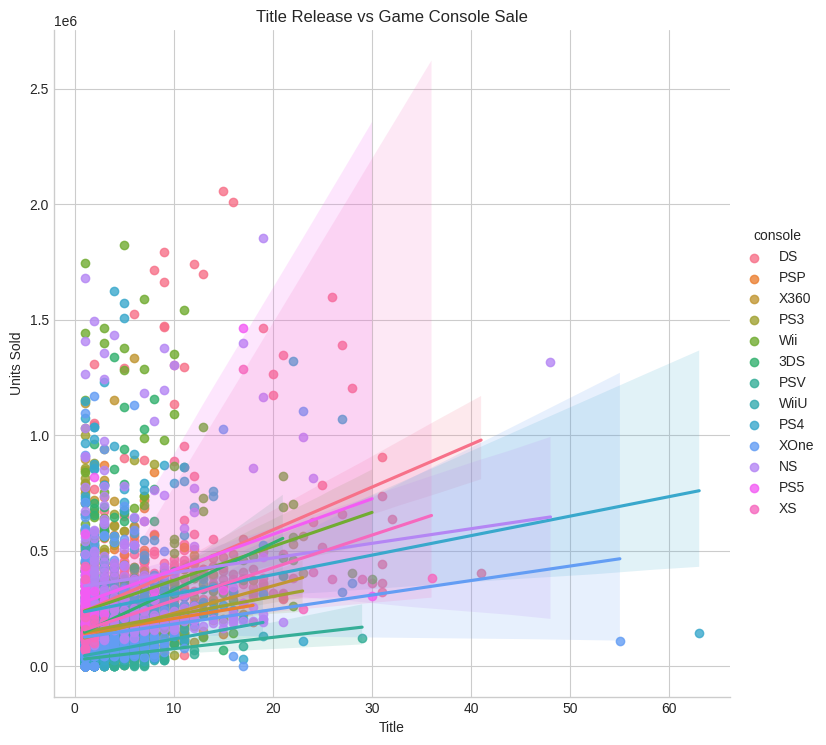

In [ ]:
plt.style.use('seaborn-v0_8-pastel')
plt.style.use('seaborn-v0_8-whitegrid')

cons_incl=game_vs_console['console'].unique()
sns.lmplot(x='title', y='units_sold', data=game_vs_console.loc[game_vs_console.console.isin(cons_incl)],
           fit_reg=True, hue='console', hue_order=cons_incl, height=7.5)

plt.xlabel("Title")
plt.ylabel("Units Sold")
plt.title("Title Release vs Game Console Sale")

# Display the plot
plt.show()

Based on the plot above, there is a positive correlation between the number of game titles released and the units sold for most platforms. As the number of game releases increases, console sales tend to increase as well.

We can see that there are obvious periodic patterns for all the consoles.
The period is around 50 weeks, that is to say, a yearly cycle.
Consequently, the cyclic autocorrelation of console sales can be a factor.
If the release of a game meets the yearly pattern of augmentation of console sales, it will be tough to conclude the causation.


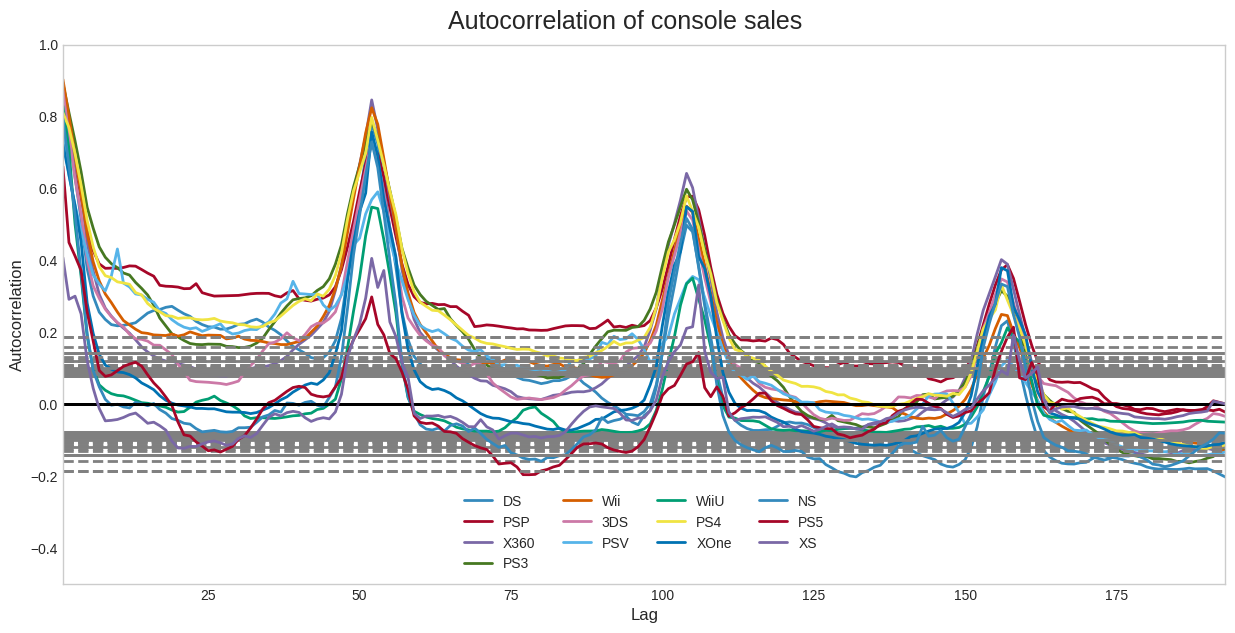

In [ ]:
# Console sales' autocorrelation
plt.style.use('bmh')
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(figsize=(15,7))
for con in cons_incl:
    one_console = wcs[wcs['console']==con]
    ax = autocorrelation_plot(one_console['units_sold'], linewidth=2, label=con)

ax.set_ylim(-0.5)
plt.legend(ncol=4, loc='lower center')
fig.suptitle("Autocorrelation of console sales", y=0.93, fontsize=18);

print('We can see that there are obvious periodic patterns for all the consoles.')
print('The period is around 50 weeks, that is to say, a yearly cycle.')
print('Consequently, the cyclic autocorrelation of console sales can be a factor.')
print('If the release of a game meets the yearly pattern of augmentation of console sales, it will be tough to conclude the causation.')

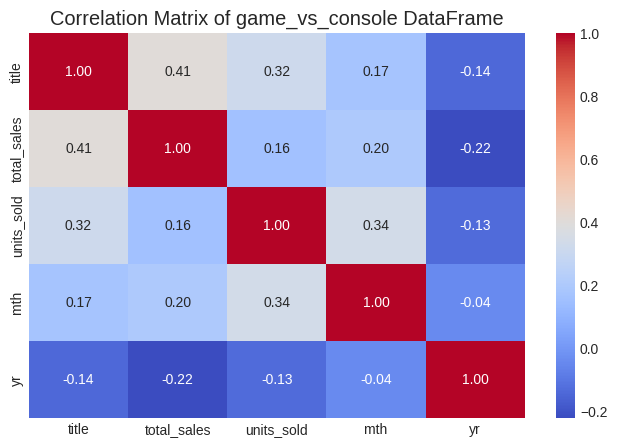

                title  total_sales  units_sold       mth        yr
title        1.000000     0.407236    0.321276  0.172231 -0.141443
total_sales  0.407236     1.000000    0.160025  0.198961 -0.220937
units_sold   0.321276     0.160025    1.000000  0.340257 -0.134679
mth          0.172231     0.198961    0.340257  1.000000 -0.042411
yr          -0.141443    -0.220937   -0.134679 -0.042411  1.000000


In [ ]:
numeric_columns = game_vs_console.select_dtypes(include=[float, int]).columns
numeric_df = game_vs_console[numeric_columns]

correlation_matrix = numeric_df.corr()

plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of game_vs_console DataFrame')
plt.show()

print(correlation_matrix)

The heatmap above shows that the correlation between units_sold and other variables is generally weak, with the highest Pearson correlation coefficient of only 0.32 being observed with 'title'.

RMSE: 184254.82789065217
R²: 0.3081684360115302


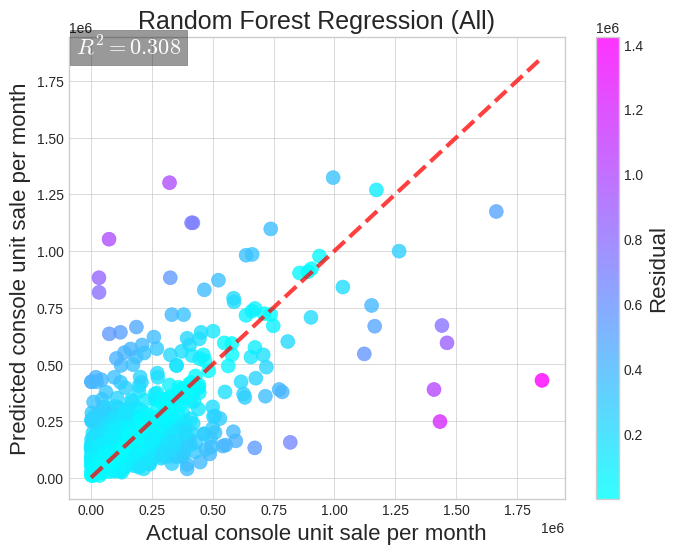

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

cons_incl = game_vs_console['console'].unique()
X = game_vs_console.loc[game_vs_console.console.isin(cons_incl), ['title', 'total_sales', 'mth', 'week_num']]
y = game_vs_console.loc[game_vs_console.console.isin(cons_incl), 'units_sold']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train_scaled, y_train)

y_pred = rf_regressor.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

def plot_regression(y_true, y_pred, title="", axis_label=""):
    y_residual = np.abs(y_true - y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    scatter = ax.scatter(y_true, y_pred, c=y_residual, cmap='cool', marker='o', s=100, alpha=0.8)
    ax.set_xlabel('Actual ' + axis_label, fontsize=16)
    ax.set_ylabel('Predicted ' + axis_label, fontsize=16)
    ax.set_title(title, fontsize=18)
    ax.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', alpha=0.75, linewidth=3)
    cbar = plt.colorbar(scatter)
    cbar.set_label('Residual', rotation=90, fontsize=16)
    plt.figtext(0.2, 0.85, f"$R^2 = {r2:.3f}$", fontsize=16, ha="center", backgroundcolor=(0, 0, 0, 0.4), color="w")
    plt.show()

plot_regression(y_test, y_pred, title="Random Forest Regression (All)", axis_label="console unit sale per month")


Its overall accuracy is limited (R² = 0.308). The model performs better in the low-sales region but shows significant errors in the high-sales region.
Most prediction errors are small, but there are significant errors for some high-sales points. This indicates that the model struggles with extreme values and may require further data processing or more complex modeling techniques.Most data points are concentrated in the lower-left corner, indicating that console sales are primarily in the low-sales range. The model performs well in this region, but its performance is unstable for high-sales data points.

#4. CONCLUSIONS

Our initial analysis of the correlation between flagship games and console sales revealed that a positive impact was not consistently observed across all platforms, and the effects tended to be transient. Next, we investigated the impact of the total number of game releases on console sales. Our results showed that platforms with a higher number of game releases generally experienced a gradual increase in sales, indicating a long-term effect. Autocorrelation plots and Random Forest models were utilized to further examine the factors influencing console sales. The results indicated a low correlation with other variables and a pronounced cyclical pattern in sales data. This cyclical nature suggests that periodic events, such as seasonal promotions and holiday shopping, may be significant drivers of console sales.